In [20]:
from pathlib import Path
import PIL
import cv2
from ufish.api import UFish
from cellpose import models
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects
from skimage.morphology import diamond, ball, dilation
from skimage.segmentation import watershed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

# Cancer pathology samples
'''
Dual fusion

Separation probe

Trisomy 8
normal: 2r, abnormal: 3r
'''
# Load the image
data_dir = "./data/"
img_paths = {
    path.stem: path for path in Path(data_dir).glob("*.TIF")
}

print(img_paths)

images = {
    name: np.array(PIL.Image.open(path))
    for name, path in img_paths.items()
}

# initialize cellpose model
cp = models.Cellpose(gpu=False, model_type="nuclei")

def segment_cells(img, ch=2, area_threshold=1000, centroid_distance_threshold=90, 
                  axis_ratio_threshold=0.9):
    """Segment cells using cellpose model and remove masks based on centroid distance and axis ratio."""
    img = img[:, :, ch]
    masks, _, _, _ = cp.eval(img, diameter=70, flow_threshold=1.2, cellprob_threshold=-1.0)
    masks = remove_small_objects(masks, min_size=1000)
    labeled_masks = label(masks)
    props = regionprops(labeled_masks)
    centroids = np.array([prop.centroid for prop in props])
    distances = cdist(centroids, centroids)
    for i in range(len(props)):
        if props[i].area > area_threshold:
            axis_ratio = props[i].minor_axis_length / props[i].major_axis_length
            distances_to_other_centroids = distances[i, :]
            distances_to_other_centroids[i] = np.inf
            if np.min(distances_to_other_centroids) < centroid_distance_threshold or axis_ratio < axis_ratio_threshold:
                masks[labeled_masks == props[i].label] = 0
    return masks

def extract_cell_rois(image, masks):
    cell_rois = []
    cell_masks = []   
    for ch in range(image.shape[2]):
        ch_image = image[:, :, ch]
        binary_mask = (masks > 0).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)       
        channel_cell_rois = []
        channel_cell_masks = []        
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cell_roi = ch_image[y:y+h, x:x+w]
            cell_mask = binary_mask[y:y+h, x:x+w]

            scale_factor = min(128 / h, 128 / w)
            if scale_factor < 1:
                new_w, new_h = int(w * scale_factor), int(h * scale_factor)
                cell_roi = cv2.resize(cell_roi, (new_w, new_h))
                cell_mask = cv2.resize(cell_mask, (new_w, new_h))
                w, h = new_w, new_h

            padded_roi = np.zeros((128, 128), dtype=ch_image.dtype)
            padded_mask = np.zeros((128, 128), dtype=binary_mask.dtype)

            start_y = (128 - h) // 2
            start_x = (128 - w) // 2

            padded_roi[start_y:start_y+h, start_x:start_x+w] = cell_roi
            padded_mask[start_y:start_y+h, start_x:start_x+w] = cell_mask
            
            channel_cell_rois.append(padded_roi)
            channel_cell_masks.append(padded_mask)            
        cell_rois.append(channel_cell_rois)
        cell_masks.append(channel_cell_masks)
    return np.array(cell_rois), np.array(cell_masks)

def cc_sub(im: np.ndarray, seed: np.ndarray, connectivity=2) -> np.ndarray:
    """Subtract the Connected Components in image which overlap with seed.

    :param im: mask image to be subtract CC.
    :param seed: mask image.
    :param connectivity: connectivity to calculate label, see:
    https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label

    :return: CC in im without overlap with seed.
    """
    lb = label(seed, connectivity=connectivity)
    w = watershed(im, markers=lb, connectivity=connectivity, mask=im)
    o = w > 1
    d = im ^ o
    return d

def mask_sub(oriangal: np.ndarray,
             masks: list[np.ndarray],
             ) -> np.ndarray:
    o = oriangal
    for m in masks:
        o = cc_sub(o, m)
    return o

def coordinates_to_mask(points: np.ndarray, shape: tuple or None = None) -> np.ndarray:
    points = points.astype(np.int64)
    dim_max = tuple([points[:, i].max()+1 for i in range(points.shape[1])])
    if shape is None:
        shape = dim_max
    else:
        assert len(shape) == points.shape[1]
        shape = tuple([shape[i] or dim_max[i] for i in range(points.shape[1])])
    arr = np.zeros(shape, dtype=np.bool_)
    ix = tuple(points[:, d] for d in range(points.shape[1]))
    arr[ix] = True  
    return arr

def cc_centroids(mask: np.ndarray) -> np.ndarray:
    if mask.dtype == bool:
        mask = label(mask.astype(int)) 
    ccs = regionprops(mask)
    centroids, labels = [], []
    for cc in ccs:
        centroids.append(cc.centroid)
        labels.append(cc.label)
    return np.array(centroids), np.array(labels)

def spots_sub(spots_a: np.ndarray, spots_b: np.ndarray, radius: int):
    assert spots_a.shape[1] == spots_b.shape[1]
    dim = spots_a.shape[1]
    assert 2 <= dim <= 3
    shape = tuple([max([int(pts[:, i].max()) for pts in [spots_a, spots_b]]) + 1
                   for i in range(dim)])
    mask_a = coordinates_to_mask(spots_a, shape)
    se = diamond(radius) if dim == 2 else ball(radius)
    mask_a = dilation(mask_a, se)
    mask_b = coordinates_to_mask(spots_b, shape)
    res_mask = mask_sub(mask_a, [mask_b])
    return cc_centroids(res_mask)[0]

# initialize ufish model
uf = UFish()
uf.load_weights()

def call_spots(img, ch=[0, 1], intensity_threshold=0):
    """Call spots using ufish model."""
    spots_list = []
    for c in ch:
        spots, _ = uf.predict(img[c, :, :])
        spots = spots.values
        spots = spots[img[c, spots[:, 0], spots[:, 1]] > intensity_threshold]
        spots_list.append(spots)
    return spots_list

def get_merge_spots(spots_list, max_dist=2.5, ch=[0, 1]):
    """Get the coordinates of all merged spots from multiple channels."""
    spots_ch1 = spots_list[ch[0]]
    spots_ch2 = spots_list[ch[1]]
    tree = KDTree(spots_ch1)
    dist, ind = tree.query(spots_ch2, k=1)
    merge_spots = spots_ch1[ind[dist < max_dist]]
    if len(ch) == 3:
        spots_ch3 = spots_list[ch[2]]
        if merge_spots.size > 0:  # Check if merge_spots is not empty
            tree = KDTree(merge_spots)
            dist, ind = tree.query(spots_ch3, k=1)
            merge_spots = merge_spots[ind[dist < max_dist]]       
    return merge_spots

from itertools import combinations
def assign_spots(cell_rois, signal_channels, max_dist):
    results = [] 
    cell_signals = []
    for w in range(cell_rois.shape[1]):
        spots = call_spots(cell_rois[:, w], ch=signal_channels, intensity_threshold=0.8)
        signals = {
            f"ch{i+1}" : spots[i] for i in signal_channels
        }
        for chs in combinations(signal_channels, 2):
            if spots[chs[0]].size == 0 or spots[chs[1]].size == 0:
                continue
            merged = get_merge_spots(spots, max_dist, ch=chs)
            if len(merged) > 0:  # check if merged is not empty
                name = f"ch{chs[0]+1}+ch{chs[1]+1}"
                signals[name] = merged
                for ch in chs:  # subtract spots
                    name = f"ch{ch+1}"
                    sps = spots[ch]
                    sps = spots_sub(sps, merged, radius=1)
                    signals[name] = sps
        if len(signal_channels) == 3:
            if spots[0].size == 0 or spots[1].size == 0 or spots[2].size == 0:
                continue
            merged = get_merge_spots(spots, max_dist, ch=signal_channels)
            if len(merged) > 0:  
                name = f"ch1+ch2+ch3"
                signals[name] = merged
                for name in ["ch1+ch2", "ch1+ch3", "ch2+ch3"]: # subtract spots
                    sps = signals[name]
                    sps = spots_sub(np.array(sps), np.array(merged), radius=1)
                    signals[name] = sps
        cell_signals.append(signals)
        table = {}
        table["cell_id"] = f'cell-{w}'
        for name, spots in signals.items():
            table[name] = len(spots)
        results.append(table)
    return pd.DataFrame(results), cell_signals
        
def change_ch(img):
    tmp = np.swapaxes(img,0, 1)
    tmp = np.swapaxes(tmp,1, 3)
    tmp = np.swapaxes(tmp,1, 2)
    return tmp

def plot_cell_and_spots(ax, img, mask, signals, colors):
    bmask = mask > 0
    edges = dilation(bmask>0, diamond(1)) & ~bmask
    img = img.copy()
    img[edges, :] = 255 
    ax.imshow(img)
    for name, spot in signals.items():
        ax.scatter(spot[:, 1], spot[:, 0], s=15, edgecolors=colors[name], facecolors="None", linewidths=1, label=name)


{'Dual fusion': PosixPath('data/Dual fusion.TIF'), 'separation probe': PosixPath('data/separation probe.TIF'), 'Trisomy 8': PosixPath('data/Trisomy 8.TIF')}


2024-03-08 22:21:23.959 | INFO     | ufish.api:_load_onnx:251 - Loading ONNX from /home/qzhang/.conda/envs/decode/lib/python3.9/site-packages/ufish/model/weights/v1.0-alldata-ufish_c32.onnx


2024-03-08 22:38:08.404 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 22:38:08.407 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 22:38:08.422 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 22:38:08.422 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 22:38:08.433 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 22:38:08.433 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 22:38:08.443 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 22:38:08.443 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 22:38:08.453 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 22:38:08.454 | INFO     | ufish.api:p

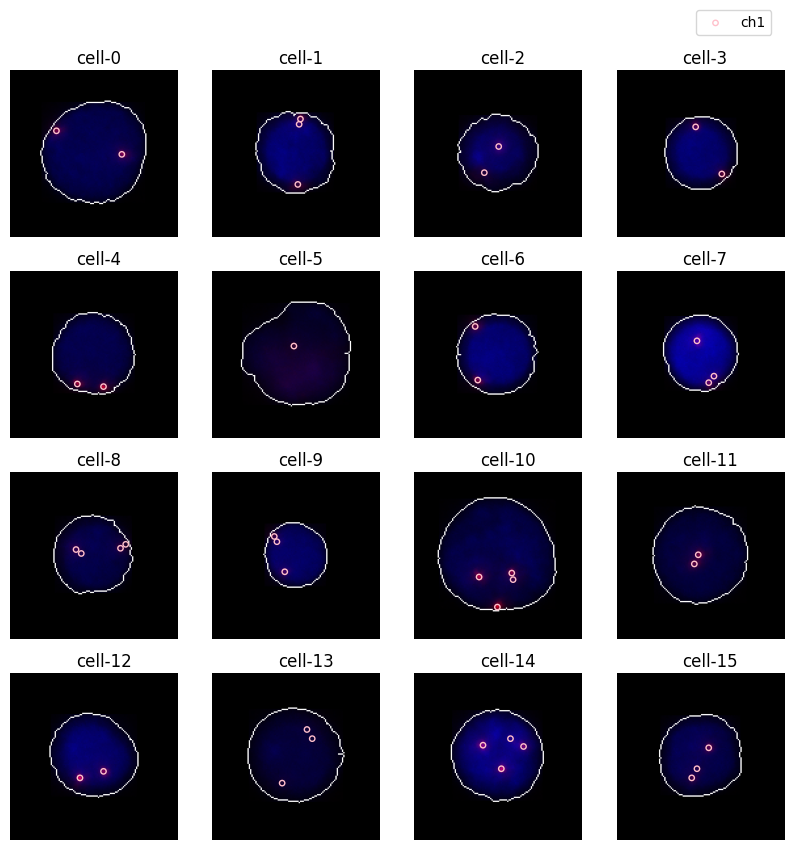

In [45]:
img = images["Trisomy 8"]

masks = segment_cells(img)

cell_rois, cell_masks = extract_cell_rois(img, masks)

df_results, cell_signals = assign_spots(cell_rois, [0], max_dist=5)

cell_rois = change_ch(cell_rois)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    plot_cell_and_spots(ax, cell_rois[i], cell_masks[-1, i], cell_signals[i], colors={"ch1": "pink", "ch2": "cyan", "ch1+ch2": "yellow"})
    ax.text(50, -5, f"cell-{i}", fontsize=12)
    ax.axis("off")

plt.legend(loc="upper center", bbox_to_anchor=(0.7, 5))
plt.show()

In [62]:
img = images["Dual fusion"]

masks = segment_cells(img)

cell_rois, cell_masks = extract_cell_rois(img, masks)

df_results, cell_signals = assign_spots(cell_rois, [0, 1], max_dist=5)

cell_rois = change_ch(cell_rois)


2024-03-08 23:10:16.078 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:10:16.082 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:10:16.097 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:10:16.097 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:10:16.110 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:10:16.111 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:10:16.120 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:10:16.121 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:10:16.133 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:10:16.134 | INFO     | ufish.api:p

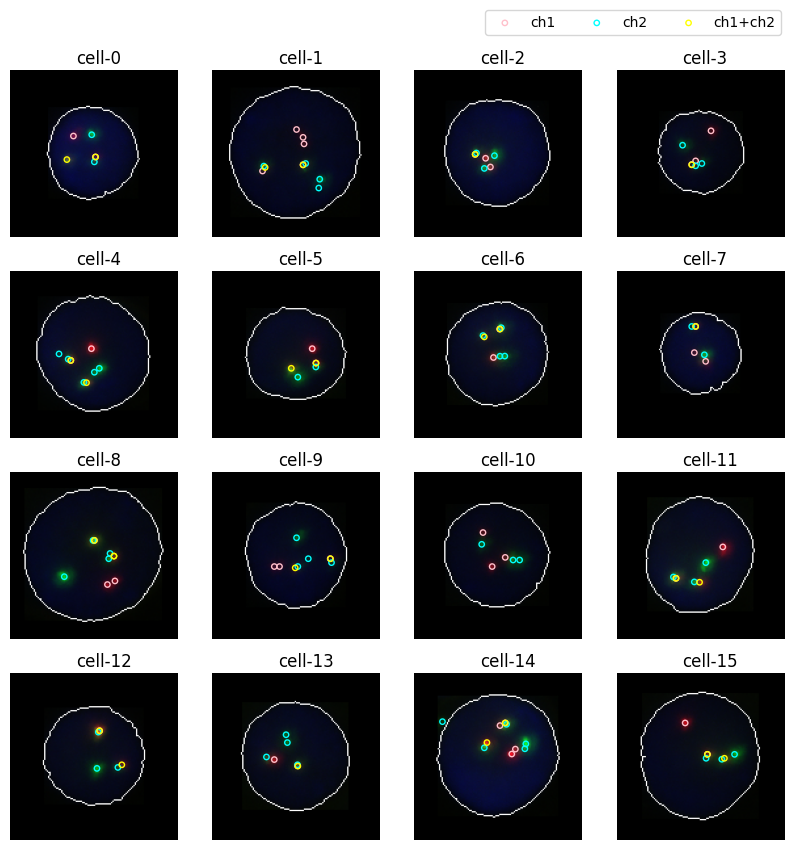

In [56]:

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    plot_cell_and_spots(ax, cell_rois[i], cell_masks[-1, i], cell_signals[i], colors={"ch1": "pink", "ch2": "cyan", "ch1+ch2": "yellow"})
    ax.text(50, -5, f"cell-{i}", fontsize=12)
    ax.axis("off")

plt.legend(loc="upper center", bbox_to_anchor=(0.1, 5), ncols=3)
plt.show()

In [63]:
img = images["separation probe"]

masks = segment_cells(img)

cell_rois, cell_masks = extract_cell_rois(img, masks)

df_results, cell_signals = assign_spots(cell_rois, [0, 1], max_dist=5)

cell_rois = change_ch(cell_rois)


2024-03-08 23:26:43.596 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:26:43.599 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:26:43.615 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:26:43.616 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:26:43.631 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:26:43.632 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:26:43.643 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:26:43.644 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-08 23:26:43.658 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-08 23:26:43.659 | INFO     | ufish.api:p

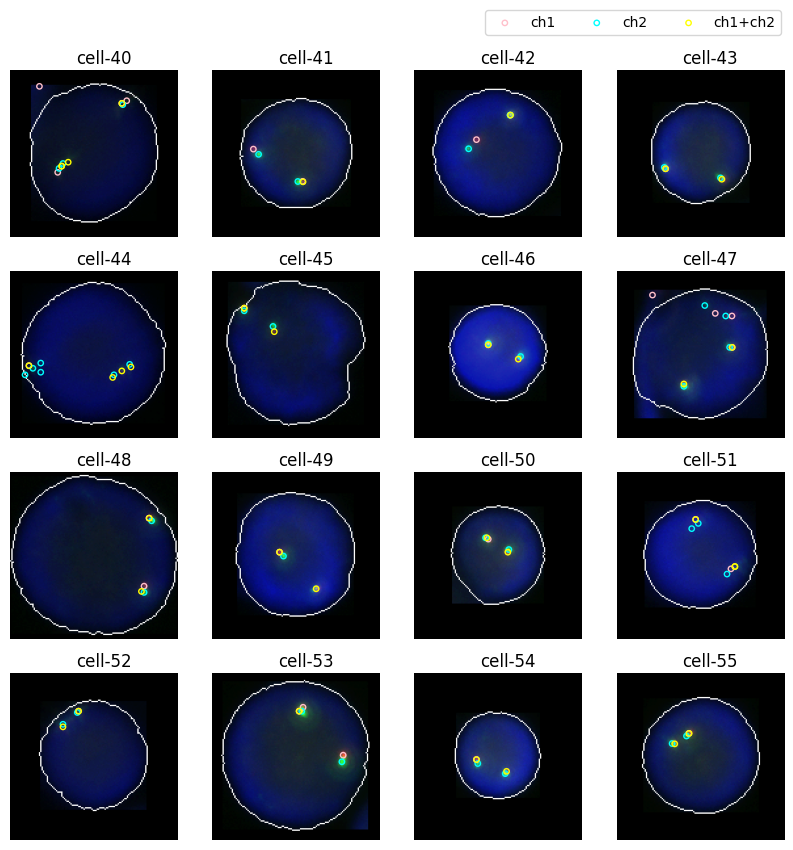

In [61]:

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flat, start=40):
    plot_cell_and_spots(ax, cell_rois[i], cell_masks[-1, i], cell_signals[i], colors={"ch1": "pink", "ch2": "cyan", "ch1+ch2": "yellow"})
    ax.text(50, -5, f"cell-{i}", fontsize=12)
    ax.axis("off")

plt.legend(loc="upper center", bbox_to_anchor=(0.1, 5), ncols=3)
plt.show()